In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalamos la librería Unsloth, que facilita el fine-tuning eficiente de modelos LLM.
# Esta herramienta es especialmente útil para trabajar con LoRA y optimizar el rendimiento en GPUs limitadas.
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-8snz6ynu
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-8snz6ynu
  Resolved https://github.com/unslothai/unsloth.git to commit 5b10dbd497315804b6de40ca25d7541c3b460924
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2025.5.7-py3-none-any.whl size=265655 sha256=108e8a7ea548a2533816ff7fdc37a41c6f4efba2fe7c02fc1ce06b10a4d33278
  Stored in directory: /tmp/pip-ephem-wheel-cache-kw8hzt_5/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
  Attempting uninstall: unsloth
    Found existing installation: unsloth 2025.5.7
    Uninstalling unsloth-2025.5.7:
      Successfully uninstalled unsloth-2025.5.7


In [ ]:
# Instalamos la librería python-dotenv, que nos permite cargar variables de entorno
# desde un archivo .env. Esto es útil para gestionar claves API u otras configuraciones sensibles sin exponerlas directamente en el código.
!pip install python-dotenv

In [ ]:
# Comprobamos si hay una GPU disponible para aprovechar la aceleración por hardware
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Hay %d GPU(s) disponibles.' % torch.cuda.device_count())
    print('Vamos a usar la GPU:', torch.cuda.get_device_name(0))
else:
    # Si no hay GPU, usamos la CPU
    device = torch.device("cpu")
    print('No hay GPU disponible, Unsloth no soporta uso sin GPU.')

Hay 1 GPU(s) disponibles.
Vamos a usar la GPU: Tesla T4


In [ ]:
# Importamos el modelo optimizado de Unsloth y una función para comprobar si la GPU soporta bfloat16
from unsloth import FastLanguageModel, is_bfloat16_supported

# PyTorch para gestionar el entrenamiento en GPU/CPU
import torch

# Importamos el SFTTrainer (Supervised Fine-Tuning Trainer) de TRL para entrenar el modelo con etiquetas
from trl import SFTTrainer

# HuggingFace login para acceder a modelos privados o subir los nuestros
from huggingface_hub import login

# Transformers: herramientas necesarias para cargar modelos y definir argumentos de entrenamiento
from transformers import TrainingArguments, EarlyStoppingCallback, AutoModelForCausalLM, AutoTokenizer

# Datasets de HuggingFace para cargar conjuntos de datos públicos
from datasets import load_dataset, Dataset

# Wandb para el seguimiento de experimentos (si lo activamos)
import wandb

# Pandas para manipulación de datos tabulares
import pandas as pd

# dotenv para cargar variables de entorno desde un archivo .env (por ejemplo, tokens)
from dotenv import load_dotenv

# os para interactuar con el sistema de archivos y variables de entorno
import os

# Funciones de sklearn para preparar datos y evaluar el rendimiento del modelo
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    f1_score, average_precision_score, accuracy_score, 
    precision_recall_fscore_support, precision_score, recall_score
)


In [ ]:
# Definimos la ruta base donde se encuentran los archivos del proyecto.
path = ''

In [ ]:
# Cargamos las variables de entorno definidas en el archivo .env ubicado en la carpeta 'cuadernos' dentro del path del proyecto.
load_dotenv(f'{path}/cuadernos/.env')  # Carga las variables del .env

# Obtenemos el token de HuggingFace desde las variables de entorno
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")

# Obtenemos el token de Weights & Biases (wandb) desde las variables de entorno
WANDB_TOKEN = os.getenv("WANDB_TOKEN")

In [ ]:
# Asignamos el token de HuggingFace a una variable más corta por comodidad
hf_token = HUGGINGFACE_TOKEN

# Iniciamos sesión en HuggingFace para poder descargar o subir modelos que requieran autenticación
login(hf_token)

In [ ]:
# Asignamos el token de Weights & Biases a una variable más corta
wb_token = WANDB_TOKEN

# Iniciamos sesión en wandb usando el token, para registrar métricas del entrenamiento
wandb.login(key=wb_token)

# Inicializamos un experimento en wandb con un nombre de proyecto y tipo de tarea definidos
run = wandb.init(
    project='Fine-tune-con-CoT-Tarea-1',  # Nombre del proyecto en wandb
    job_type="training",                 # Tipo de tarea (entrenamiento en este caso)
    anonymous="allow"                    # Permite registros anónimos si no se asocia un usuario
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: atorojaen (atorojaen-university-of-huelva) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Definimos los nombres de las columnas clave del dataset
COLUMN_ID = 'id'               # Identificador único de cada muestra
COLUMN_LETRA = 'lyrics'       # Columna con la letra de la canción
COLUMN_ETIQUETA = 'label'     # Columna con la etiqueta de clasificación (M/NM)
COLUMN_RAZONAMIENTO = 'reasoning'  # Columna con el razonamiento generado para CoT (Chain of Thought)

# Indicamos el tipo de razonamiento CoT utilizado (en este caso, generado con GPT-4o)
tipo_CoT = 'GPT4o'
# Nombre del modelo que vamos a utilizar para el fine-tuning
model_name = 'DeepSeek-R1-Distill-Llama-8B-unsloth-bnb-4bit'
# Ruta del archivo CSV de entrenamiento con razonamientos generados
csv_train_filepath = f'{path}/data/train_data/task1_{tipo_CoT}_dataReasoning.csv'
# Tipo de prompt a utilizar (esto se usará más adelante para construir el prompt)
tipo_prompt = 0

In [ ]:
# Mostramos la ruta del archivo que vamos a cargar
print(f"Cargando datos desde: {csv_train_filepath}")

try:
    # 1. Cargamos el DataFrame desde el CSV
    df = pd.read_csv(csv_train_filepath, encoding='utf-8', encoding_errors="replace", sep=',')

    # Mostramos las columnas encontradas en el CSV, útil para comprobar que todo se cargó bien
    print(f"Columnas encontradas en el CSV: {df.columns.tolist()}")

    # 2. División en conjuntos de entrenamiento, validación y test
    print(f"Total de filas válidas antes de dividir: {len(df)}")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[COLUMN_ETIQUETA])
    train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[COLUMN_ETIQUETA])
    print(f"División completada:")
    print(f"  - Tamaño del conjunto de Entrenamiento: {len(train_df)}")
    print(f"  - Tamaño del conjunto de Validación:  {len(valid_df)}")
    print(f"  - Tamaño del conjunto de Test:         {len(test_df)}")

    # Mostramos la distribución de clases en cada conjunto para verificar balanceo
    print("\n--- Distribución de Clases ---")
    print("Conjunto de Entrenamiento:")
    print(train_df[COLUMN_ETIQUETA].value_counts(normalize=False))

    print("\nConjunto de Validación:")
    print(valid_df[COLUMN_ETIQUETA].value_counts(normalize=False))

    print("\nConjunto de Test:")
    print(test_df[COLUMN_ETIQUETA].value_counts(normalize=False))
    print("-----------------------------")

    # Separamos las clases para aplicar oversampling
    majority_class_df = train_df[train_df[COLUMN_ETIQUETA] == 0]
    minority_class_df = train_df[train_df[COLUMN_ETIQUETA] == 1]

    # --- OVERSAMPLING de la clase minoritaria para balancear ---
    minority_oversampled_df = resample(minority_class_df,
                                       replace=True,     # Permite duplicados
                                       n_samples=600,    # Tamaño deseado para la clase minoritaria
                                       random_state=42)  # Para reproducibilidad

    # Combinamos el conjunto mayoritario original con el minoritario sobremuestreado
    train_df_balanced = pd.concat([majority_class_df, minority_oversampled_df])

    # --- UNDERSAMPLING (comentado) ---
    # Este bloque está comentado, puedes eliminarlo si no planeas usar undersampling.
    # majority_undersampled_df = resample(majority_class_df, replace=False, n_samples=600, random_state=42)
    # train_df_balanced = pd.concat([majority_undersampled_df, minority_oversampled_df])

    # Barajamos el conjunto de entrenamiento balanceado para evitar agrupamientos por clase
    train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nConjunto de Entrenamiento nuevo:")
    print(train_df_balanced[COLUMN_ETIQUETA].value_counts(normalize=False))
    print("------------------------------------------")

    # 3. Convertimos los DataFrames de pandas a datasets.Dataset, formato requerido por HuggingFace
    trainData = Dataset.from_pandas(train_df_balanced)
    validData = Dataset.from_pandas(valid_df)
    testData = Dataset.from_pandas(test_df)

    print("\nDatasets creados exitosamente.")
    print(f"Columnas en trainData: {trainData.column_names}")

except FileNotFoundError:
    print(f"Error: Archivo no encontrado en '{csv_train_filepath}'")
except Exception as e:
    print(f"Error inesperado durante la carga o división de datos: {e}")
    import traceback
    traceback.print_exc()

Cargando datos desde: /content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/data/train_data/task1_GPT4o_dataReasoning.csv
Columnas encontradas en el CSV: ['id', 'lyrics', 'reasoning', 'label']
Total de filas válidas antes de dividir: 2104
División completada:
  - Tamaño del conjunto de Entrenamiento: 1346
  - Tamaño del conjunto de Validación:  337
  - Tamaño del conjunto de Test:         421

--- Distribución de Clases ---
Conjunto de Entrenamiento:
label
0    935
1    411
Name: count, dtype: int64

Conjunto de Validación:
label
0    234
1    103
Name: count, dtype: int64

Conjunto de Test:
label
0    293
1    128
Name: count, dtype: int64
-----------------------------

Conjunto de Entrenamiento nuevo:
label
0    935
1    600
Name: count, dtype: int64
------------------------------------------

Datasets creados exitosamente.
Columnas en trainData: ['id', 'lyrics', 'reasoning', 'label']


In [ ]:
# Definimos la longitud máxima de tokens que aceptará el modelo por entrada.
# 2048 es una buena elección para modelos LLM que admiten secuencias largas.
max_seq_length = 2048

# Definimos el tipo de precisión a utilizar (None significa que se seleccionará automáticamente más adelante)
dtype = None

# Indicamos si queremos cargar el modelo en 4-bit (quantización), lo cual reduce el uso de memoria y acelera el entrenamiento
load_in_4bit = True

In [ ]:
# Cargamos el modelo y el tokenizador desde Hugging Face usando la implementación optimizada de Unsloth.
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"unsloth/{model_name}",      # Ruta al modelo distilado alojado en Hugging Face (prefijo 'unsloth/')
    max_seq_length = max_seq_length,           # Longitud máxima de entrada que el modelo puede procesar
    dtype = dtype                              # Tipo de precisión (None permite que se seleccione automáticamente)
)

==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Prueba con el modelo sin entrenar

# AHORA EMPIEZA EL FINE TUNING

# LLAMADO "ALPACA PROMPT"

In [ ]:
# Definimos dos plantillas distintas de prompt para el entrenamiento supervisado con razonamiento (Chain of Thought).
# Estas plantillas se rellenarán dinámicamente con la letra de la canción ({lyrics}),
# el razonamiento generado ({reasoning}) y la etiqueta correspondiente ({label}).

prompts_train = [
    """
    ### Instruccion
    Analiza la siguiente letra de canción y determina si contiene contenido misógino. Evalúa si incluye lenguaje, actitudes o mensajes que:
      - Degraden o deshumanicen a las mujeres.
      - Menosprecien a las mujeres de manera explícita o implícita.
      - Refuercen estereotipos negativos o dañinos sobre las mujeres.
      - Promuevan violencia física, emocional o sexual contra las mujeres.
    Piensa cuidadosamente tu respuesta y crea paso a paso una chain of thoughts para dar una respuesta logica.
    Responde únicamente con "1" si la letra es misógina o con "0" si la letra no es misógina. No proporciones ninguna explicación ni texto adicional.

    ### Letra:
    {lyrics}

    ### Respuesta:
    <think>{reasoning}</think> {label}
    """,
    
    """
    ### Instruccion
    Analiza la siguiente letra de canción y determina si contiene contenido misógino. Evalúa si incluye lenguaje, actitudes o mensajes que:
      - Degraden o deshumanicen a las mujeres (ej. como objetos, posesiones, animales; incluye deshumanización sutil).
      - Menosprecien a las mujeres de manera explícita o implícita (ej. insultos (ej. 'puta'), etiquetas generalizadoras como 'bandolera', deseo de sufrimiento).
      - Refuercen estereotipos negativos o dañinos sobre las mujeres (ej. inherentemente engañosas, 'trampas de mujer', manipuladoras).
      - Promuevan violencia (física/emocional/sexual) o control sobre ellas (ej. justificar castigo 'para que respete', competencia masculina por 'estrenarla').

    **Consideración Importante:** Evalúa el contexto general. La expresión de dolor personal o el empoderamiento femenino tras una ruptura (ej. 'se cansó de ser buena') no son misóginos *por sí solos* si no cumplen claramente los criterios anteriores.

    ### Letra:
    {lyrics}

    ### Respuesta:
    {reasoning}
    """
]


In [ ]:
# Obtenemos el token de final de secuencia (End Of Sequence) del tokenizador cargado
EOS_TOKEN = tokenizer.eos_token

# Mostramos el token EOS para verificar qué carácter utiliza el modelo como fin de secuencia
EOS_TOKEN

'<｜end▁of▁sentence｜>'

In [ ]:
# Función que toma un batch de ejemplos y construye los prompts de entrenamiento
# a partir de la plantilla definida y los datos de entrada (letra, razonamiento y etiqueta).
def formatting_prompts(examples):
    # Extraemos las listas necesarias desde el diccionario de ejemplos
    lyrics_list = examples[COLUMN_LETRA]          # Lista de letras de canciones
    labels_list = examples[COLUMN_ETIQUETA]       # Lista de etiquetas (0 o 1)
    reasonings_list = examples[COLUMN_RAZONAMIENTO]  # Lista de razonamientos CoT

    texts = []  # Aquí guardaremos los prompts generados con el formato final

    # Recorremos cada ejemplo del batch y generamos el texto correspondiente
    for lyric, label, reasoning in zip(lyrics_list, labels_list, reasonings_list):
        label_str = str(label).strip()  # Convertimos la etiqueta a string (por si viene como número)

        # Usamos el tipo de prompt seleccionado (tipo_prompt) para formatear cada entrada
        text = prompts_train[tipo_prompt].format(
            lyrics=str(lyric),
            reasoning=str(reasoning),
            label=label_str
        ) + EOS_TOKEN  # Añadimos el token de fin de secuencia al final

        texts.append(text)  # Añadimos el prompt formateado a la lista

    # Devolvemos un diccionario con el texto final, listo para tokenizar y entrenar
    return {
        "text": texts
    }


In [ ]:
# Mostramos las columnas presentes en el dataset de entrenamiento antes de aplicar el mapeo
print(f"Columnas en trainData antes de mapear: {trainData.column_names}")

# Mostramos las columnas presentes en el dataset de validación antes de aplicar el mapeo
print(f"Columnas en validData antes de mapear: {validData.column_names}")


Formateando datasets para entrenamiento CoT...
Columnas en trainData antes de mapear: ['id', 'lyrics', 'reasoning', 'label']
Columnas en validData antes de mapear: ['id', 'lyrics', 'reasoning', 'label', '__index_level_0__']


In [ ]:
# Aplicamos la función 'formatting_prompts' al dataset de entrenamiento.
# Usamos `batched=True` para que procese varios ejemplos a la vez, lo que mejora el rendimiento.
# Con `remove_columns`, eliminamos las columnas originales (lyrics, label, reasoning, etc.)
# y nos quedamos solo con la columna 'text' que contiene el prompt completo.
dataset_finetune = trainData.map(formatting_prompts, batched=True, remove_columns=trainData.column_names)

# Hacemos lo mismo con el dataset de validación
eval_finetune = validData.map(formatting_prompts, batched=True, remove_columns=validData.column_names)

# Mostramos el primer ejemplo ya formateado (solo texto, listo para tokenizar y entrenar)
dataset_finetune["text"][0]

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

'\n            ### Instruccion\n            Analiza la siguiente letra de canción y determina si contiene contenido misógino. Evalúa si incluye lenguaje, actitudes o mensajes que:\n              - Degraden o deshumanicen a las mujeres.\n              - Menosprecien a las mujeres de manera explícita o implícita.\n              - Refuercen estereotipos negativos o dañinos sobre las mujeres.\n              - Promuevan violencia física, emocional o sexual contra las mujeres.\n            Piensa cuidadosamente tu respuesta y crea paso a paso una chain of thoughts para dar una respuesta logica.\n            Responde únicamente con "1" si la letra es misógina o con "0" si la letra no es misógina. No proporciones ninguna explicación ni texto adicional.\n\n            ### Letra:\n            me dijo: se hizo tarde, ya no se ve el sol so? y que le hiciera un favor, oh-oh-oh de llevarla a su casa a conseguir alcohol pina records a conocernos mejor maldy se dio cuenta que ella tenía un plan vida l

# Calculo longitud de los prompts

Se calcularon las longitudes de 1418 prompts formateados.
Longitud máxima encontrada (incl. special tokens): 4147


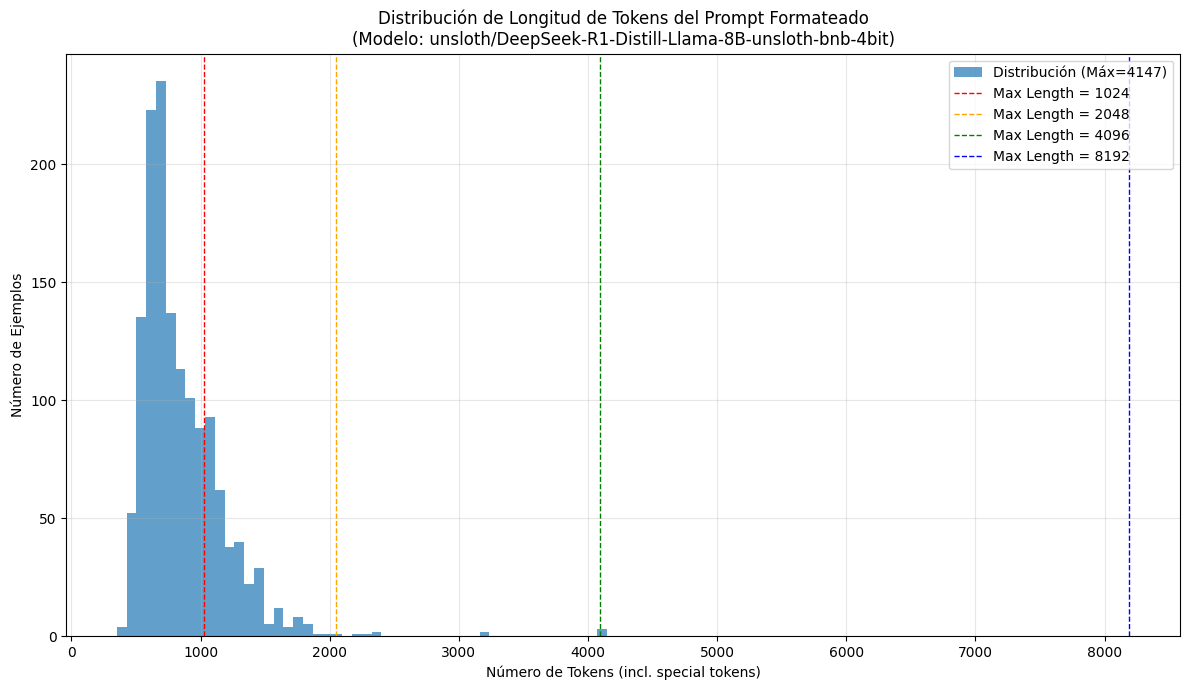

Porcentaje de canciones con más de 1024 tokens: 24.12%
Porcentaje de canciones con más de 2048 tokens: 0.71%
Porcentaje de canciones con más de 4096 tokens: 0.21%
Porcentaje de canciones con más de 8192 tokens: 0.00%


In [ ]:
# Importamos matplotlib para visualizar la distribución de longitud de los prompts
import matplotlib.pyplot as plt

# Calculamos la longitud (en número de tokens) de cada ejemplo del dataset de entrenamiento ya formateado
# Usamos add_special_tokens=False para centrarnos solo en los tokens del contenido
token_lengths = [len(tokenizer.encode(text, add_special_tokens=False)) for text in dataset_finetune["text"]]
print(f"Se calcularon las longitudes de {len(token_lengths)} prompts formateados.")

# Verificación rápida por si algo salió mal y no hay datos
if not token_lengths:
    print("La lista de longitudes está vacía. Verifica el dataset y la columna 'text'.")
else:
    # 1. Obtenemos la longitud máxima de tokens en todo el dataset
    max_len = max(token_lengths)
    print(f"Longitud máxima encontrada (incl. special tokens): {max_len}")

    # 2. Creamos un histograma para visualizar la distribución de longitudes de prompts
    plt.figure(figsize=(12, 7))
    plt.hist(token_lengths, bins=50, alpha=0.7, label=f'Distribución (Máx={max_len})')

    # Añadimos líneas verticales como referencia para distintas longitudes comunes de entrada
    plt.axvline(1024, color='red', linestyle='dashed', linewidth=1, label='Max Length = 1024')
    plt.axvline(2048, color='orange', linestyle='dashed', linewidth=1, label='Max Length = 2048')
    plt.axvline(4096, color='green', linestyle='dashed', linewidth=1, label='Max Length = 4096')
    plt.axvline(8192, color='blue', linestyle='dashed', linewidth=1, label='Max Length = 8192')

    # Etiquetas del gráfico
    plt.xlabel('Número de Tokens (incl. special tokens)')
    plt.ylabel('Número de Ejemplos')
    plt.title(f'Distribución de Longitud de Tokens del Prompt Formateado\n(Modelo: {tokenizer.name_or_path})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Calculamos porcentajes de ejemplos que superan ciertos umbrales de longitud
    print(f"Porcentaje de canciones con más de 1024 tokens: {sum(l > 1024 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 2048 tokens: {sum(l > 2048 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 4096 tokens: {sum(l > 4096 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 8192 tokens: {sum(l > 8192 for l in token_lengths) / len(token_lengths) * 100:.2f}%")


# ELIMINO LOS PROMPTS QUE SUPEREN LOS 2048 TOKENS

In [ ]:
# Función auxiliar que comprueba si un ejemplo tiene una longitud de tokens
# menor o igual que el límite definido por max_seq_length.
# Esto nos permitirá filtrar ejemplos demasiado largos para el modelo.

def limit_tokens(example):
    return len(tokenizer.encode(str(example['text']), add_special_tokens=True)) <= max_seq_length

In [ ]:
# Mostramos el tamaño original de los datasets antes de aplicar el filtro por longitud de tokens
print(f"Tamaño original de dataset_finetune: {len(dataset_finetune)}")
print(f"Tamaño original de eval_finetune: {len(eval_finetune)}")

# Filtramos los ejemplos que exceden la longitud máxima permitida por el modelo
# Esto evita errores durante el entrenamiento cuando el input es demasiado largo
dataset_finetune = dataset_finetune.filter(limit_tokens, batched=False)
eval_finetune = eval_finetune.filter(limit_tokens, batched=False)

# Mostramos el tamaño de los datasets después del filtrado
print(f"Tamaño filtrado de dataset_finetune: {len(dataset_finetune)}")
print(f"Tamaño filtrado de eval_finetune: {len(eval_finetune)}")

Tamaño original de dataset_finetune: 1535
Tamaño original de eval_finetune: 337


Filter:   0%|          | 0/1535 [00:00<?, ? examples/s]

Filter:   0%|          | 0/337 [00:00<?, ? examples/s]

Tamaño filtrado de dataset_finetune: 1526
Tamaño filtrado de eval_finetune: 335


# Parametros del train

In [ ]:
# Número de ejemplos procesados por dispositivo en cada paso (bajo por limitación de memoria)
per_device_batch = 1

# Acumulamos gradientes durante varios pasos antes de hacer una actualización de pesos.
# Esto permite simular un batch más grande sin agotar la memoria.
gradient_accum_steps = 8  # Si hay problemas de OOM (out of memory), se puede bajar a 4

# Batch efectivo real (batch_size lógico)
effective_batch_size = per_device_batch * gradient_accum_steps  # = 8

# Número de épocas a entrenar
epochs = 5

# Tamaño del conjunto de entrenamiento (número de ejemplos tras filtrado)
num_train_examples = 1526

# Número de pasos por época (cuántas actualizaciones de pesos por época)
steps_per_epoch = num_train_examples // effective_batch_size  # ~177

# Número total de pasos de entrenamiento
total_steps = steps_per_epoch * epochs  # ~296

# Calculamos el número de pasos para el warmup (10% del total)
warmup_steps_calculated = int(total_steps * 0.10)  # ~30

# Definimos cada cuántos pasos queremos:
# evaluar el modelo, loguear métricas y guardar checkpoints
eval_logging_save_steps = 25

# Hiperparámetros de LoRA (Low-Rank Adaptation), usados en fine-tuning eficiente
lora_r = 16
lora_alpha = 16

# Tasa de aprendizaje inicial para el optimizador
learning_rate = 2e-5

# Mostramos toda la configuración calculada
print(f"Configuración de Entrenamiento:")
print(f"  - Per Device Batch Size: {per_device_batch}")
print(f"  - Gradient Accumulation Steps: {gradient_accum_steps}")
print(f"  - Effective Batch Size: {effective_batch_size}")
print(f"  - Num Train Examples: {num_train_examples}")
print(f"  - Epochs: {epochs}")
print(f"  - Steps per Epoch: ~{steps_per_epoch}")
print(f"  - Total Steps: ~{total_steps}")
print(f"  - Warmup Steps: {warmup_steps_calculated}")
print(f"  - Eval/Log/Save Steps: {eval_logging_save_steps}")
print(f"  - LoRA R: {lora_r}")
print(f"  - LoRA Alpha: {lora_alpha}")

Configuración de Entrenamiento:
  - Per Device Batch Size: 1
  - Gradient Accumulation Steps: 8
  - Effective Batch Size: 8
  - Num Train Examples: 1526
  - Epochs: 5
  - Steps per Epoch: ~190
  - Total Steps: ~950
  - Warmup Steps: 95
  - Eval/Log/Save Steps: 25
  - LoRA R: 16
  - LoRA Alpha: 16


In [ ]:
# Aplicamos LoRA (Low-Rank Adaptation) al modelo base para permitir un fine-tuning eficiente.
# Esto nos permite entrenar solo unas pocas capas adaptativas en lugar de todo el modelo,
# reduciendo drásticamente el uso de memoria y el tiempo de entrenamiento.

model_lora = FastLanguageModel.get_peft_model(
    model,                          # Modelo base sobre el que aplicamos LoRA
    r=lora_r,                       # Rango bajo: controla cuántos parámetros se entrenan (16 es un valor común)
    
    # Capas del modelo donde se insertarán los adaptadores LoRA:
    # - q_proj, k_proj, v_proj, o_proj → atención
    # - gate_proj, up_proj, down_proj → MLP
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    
    lora_alpha=lora_alpha,          # Factor de escalado LoRA: controla la intensidad de la adaptación
    lora_dropout=0.05,              # Pequeño dropout para regularización durante el fine-tuning
    bias="none",                    # No entrenamos los sesgos originales del modelo

    # Activamos gradient checkpointing para reducir uso de memoria (aunque ralentiza el entrenamiento)
    use_gradient_checkpointing="unsloth",  

    random_state=3407,              # Semilla para asegurar reproducibilidad
    use_rslora=False,               # No usamos rslora (una variante más compleja de LoRA)
    loftq_config=None               # No usamos LoFTQ (cuantización de entrenamiento)
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.5.7 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [ ]:
# Inicializamos el trainer para hacer fine-tuning supervisado (SFT) con prompts de tipo Chain of Thought
trainer = SFTTrainer(
    model = model_lora,                   # Modelo base con adaptadores LoRA ya aplicados
    tokenizer = tokenizer,                # Tokenizador correspondiente al modelo
    train_dataset = dataset_finetune,     # Dataset de entrenamiento formateado
    eval_dataset = eval_finetune,         # Dataset de validación para evaluar en cada checkpoint
    dataset_text_field = "text",          # Campo que contiene el texto ya formateado
    max_seq_length = max_seq_length,      # Longitud máxima de entrada para cada ejemplo
    dataset_num_proc = 2,                 # Número de procesos para acelerar el preprocesamiento del dataset

    # Añadimos callback para early stopping si no mejora la evaluación durante 3 pasos consecutivos
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],

    # Argumentos de entrenamiento
    args = TrainingArguments(
        per_device_train_batch_size = per_device_batch,            # Batch por dispositivo (ajustado a VRAM disponible)
        gradient_accumulation_steps = gradient_accum_steps,        # Acumulación de gradientes para simular batches mayores
        #max_steps = 60,  #Se puede usar para pruebas rápidas limitando los pasos

        num_train_epochs = epochs,                    # Número de pasadas completas sobre el dataset
        warmup_steps = warmup_steps_calculated,       # Warmup gradual de la tasa de aprendizaje
        learning_rate = learning_rate,                # Tasa de aprendizaje (ajustada para LoRA)

        # Selección de precisión: BF16 si es compatible, sino FP16
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),

        logging_steps = eval_logging_save_steps,      # Log de métricas cada N pasos

        optim = "adamw_8bit",                         # Optimizador AdamW con pesos en 8-bit (ahorro de VRAM)
        weight_decay = 0.01,                          # Penalización para evitar overfitting
        lr_scheduler_type = "linear",                 # Planificador lineal de tasa de aprendizaje
        seed = 3407,                                  # Semilla para reproducibilidad

        output_dir = f"{path}/cuadernos/outputs",     # Carpeta para guardar checkpoints del modelo

        # Evaluación, logging y guardado se hacen cada N pasos (no por epoch)
        eval_strategy = "steps",
        eval_steps = eval_logging_save_steps,
        save_strategy = "steps",
        save_steps = eval_logging_save_steps,

        save_total_limit = 4,                         # Solo guardamos los últimos 4 checkpoints para ahorrar espacio
        load_best_model_at_end = True,                # Recuperamos automáticamente el mejor modelo al final
        metric_for_best_model = "eval_loss",          # La métrica a observar es la pérdida de validación
        greater_is_better = False,                    # Menor pérdida indica mejor modelo

        report_to = "wandb",                          # Registramos todo en Weights & Biases
    ),
)


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1526 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/335 [00:00<?, ? examples/s]

#Iniciando training

In [ ]:
# --- Ejecutar Entrenamiento ---
print("\nIniciando entrenamiento...")
trainer_stats = trainer.train()
print("Entrenamiento completado.")


Iniciando entrenamiento...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,526 | Num Epochs = 5 | Total steps = 950
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


RuntimeError: PassManager::run failed

In [ ]:
# SOLO PARA SEGUIR DESDE EL CHECKPOINT

# Usamos 'resume_from_checkpoint=True' para continuar desde el último checkpoint guardado,
# útil si el entrenamiento fue interrumpido o si queremos reanudar sin empezar desde cero.

trainer_stats = trainer.train(resume_from_checkpoint = True)


In [ ]:
# Finalizamos el seguimiento del experimento en Weights & Biases (wandb).
# Esto es importante para asegurarnos de que todo se registre correctamente y cerrar la sesión limpia.

wandb.finish()

#Guardando el modelo

In [ ]:
final_save_path = f'{path}/models/Model_{model_name}-CoT_{tipo_CoT}-R_{lora_r}-Alpha_{lora_alpha}-LR_{learning_rate}-Tarea_1'

In [ ]:
# Guardamos el modelo entrenado y el tokenizador en la ruta final definida
print(f"\nGuardando el mejor modelo en: {final_save_path}")

# Guarda los pesos del modelo (el mejor según eval_loss si se usó load_best_model_at_end=True)
trainer.save_model(final_save_path)

# Guarda el tokenizador asociado, necesario para poder usar el modelo después
tokenizer.save_pretrained(final_save_path)

print("Modelo y tokenizer guardados.")

# Probando el modelo entrenado :)

In [ ]:
# Cargamos el modelo fine-tuneado y el tokenizador desde la ruta donde lo guardamos anteriormente.
# Esto nos permite usarlo para hacer predicciones o evaluación posterior.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = final_save_path,       # Ruta donde se guardó el modelo (puede ser local o en Hugging Face si lo subiste)
    max_seq_length = 2048,              # Longitud máxima de secuencia a procesar
    dtype = dtype                       # Tipo de precisión (se mantiene igual que en el entrenamiento)
)

==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

Unsloth 2025.5.7 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [12]:
prompts_test = [ """
            ### Instruccion
            Analiza la siguiente letra de canción y determina si contiene contenido misógino. Evalúa si incluye lenguaje, actitudes o mensajes que:
              - Degraden o deshumanicen a las mujeres.
              - Menosprecien a las mujeres de manera explícita o implícita.
              - Refuercen estereotipos negativos o dañinos sobre las mujeres.
              - Promuevan violencia física, emocional o sexual contra las mujeres.
            Piensa cuidadosamente tu respuesta y crea paso a paso una chain of thoughts para dar una respuesta logica.
            Responde únicamente con "1" si la letra es misógina o con "0" si la letra no es misógina. No proporciones ninguna explicación ni texto adicional.

            ### Letra:
            {lyrics}

            ### Respuesta:
            <think>""",
            """
            ### Instruccion
            Analiza la siguiente letra de canción y determina si contiene contenido misógino. Evalúa si incluye lenguaje, actitudes o mensajes que:
              - Degraden o deshumanicen a las mujeres (ej. como objetos, posesiones, animales; incluye deshumanización sutil).
              - Menosprecien a las mujeres de manera explícita o implícita (ej. insultos (ej. 'puta'), etiquetas generalizadoras como 'bandolera', deseo de sufrimiento).
              - Refuercen estereotipos negativos o dañinos sobre las mujeres (ej. inherentemente engañosas, 'trampas de mujer', manipuladoras).
              - Promuevan violencia (física/emocional/sexual) o control sobre ellas (ej. justificar castigo 'para que respete', competencia masculina por 'estrenarla').

            **Consideración Importante:** Evalúa el contexto general. La expresión de dolor personal o el empoderamiento femenino tras una ruptura (ej. 'se cansó de ser buena') no son misóginos *por sí solos* si no cumplen claramente los criterios anteriores.

            ### Letra:
            {lyrics}

            ### Respuesta:
            <think>
            """
          ]

In [ ]:
# --- Aseguramos que el modelo esté en modo evaluación antes de hacer inferencias ---

# Ponemos el modelo en modo evaluación para desactivar capas como dropout y batchnorm (si las hubiese)
model.eval()

# Preparamos el modelo con las optimizaciones específicas de Unsloth para inferencia rápida
FastLanguageModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (

#Prueba para ver los FP y FN

#Prueba para ejecutar solo 40 canciones

In [ ]:
import random

# --- SELECCIÓN DEL SUBCONJUNTO DE testData PARA EVALUACIÓN MANUAL ---

num_samples_label_1 = 20  # Número de ejemplos misóginos a seleccionar
num_samples_label_0 = 20  # Número de ejemplos no misóginos a seleccionar

# 1. Separamos los ejemplos por clase, convirtiendo la etiqueta a string por seguridad
examples_label_1 = [ex for ex in testData if str(ex[COLUMN_ETIQUETA]).strip() == '1']
examples_label_0 = [ex for ex in testData if str(ex[COLUMN_ETIQUETA]).strip() == '0']

# 2. Evitamos pedir más muestras de las que hay disponibles por clase
num_samples_label_1 = min(num_samples_label_1, len(examples_label_1))
num_samples_label_0 = min(num_samples_label_0, len(examples_label_0))

# 3. Seleccionamos aleatoriamente los ejemplos de cada clase
random.seed(42)  # Fijamos semilla para que la selección sea reproducible
selected_examples_1 = random.sample(examples_label_1, num_samples_label_1)
selected_examples_0 = random.sample(examples_label_0, num_samples_label_0)

# 4. Combinamos los ejemplos seleccionados y mezclamos el orden para evitar sesgos
sampled_testData = selected_examples_1 + selected_examples_0
random.shuffle(sampled_testData)

# Reasignamos testData al subconjunto para usarlo en la evaluación o inferencia
testData = sampled_testData

# Informamos del resultado de la selección
print(f"--- Preparando evaluación con un subconjunto ---")
print(f"Seleccionados {len(selected_examples_1)} ejemplos con etiqueta '1'.")
print(f"Seleccionados {len(selected_examples_0)} ejemplos con etiqueta '0'.")
print(f"Total ejemplos en el subconjunto de evaluación: {len(sampled_testData)}")

--- Preparando evaluación con un subconjunto ---
Seleccionados 20 ejemplos con etiqueta '1'.
Seleccionados 20 ejemplos con etiqueta '0'.
Total ejemplos en el subconjunto de evaluación: 40


#Ejecutar evaluación

In [ ]:
# --- Inicializamos listas y variables para guardar resultados ---
true_labels = []                # Etiquetas reales del conjunto de test
predicted_labels = []          # Etiquetas predichas por el modelo
failed_extractions_count = 0   # Contador de predicciones donde no se pudo extraer la etiqueta correctamente
test_results_details = []      # Detalles de cada predicción para análisis posterior
output_csv_filename = "track_1_predictions.csv"  # Nombre del archivo de salida (si se guarda CSV)
csv_rows = [['id', 'label']]   # Cabecera del CSV, en formato de envío oficial
label_map = {'1': 'M', '0': 'NM'}  # Mapear números a etiquetas oficiales

from tqdm.notebook import tqdm  # Barra de progreso para evaluar visualmente
import re

print(f"\n--- Iniciando evaluación en el Test Set ({len(testData)} ejemplos) ---")

# Recorremos cada ejemplo del subconjunto de test para hacer inferencia y evaluación
for example in tqdm(testData, desc="Evaluando Test Set"):
    try:
        lyrics = str(example[COLUMN_LETRA])
        true_label = str(example[COLUMN_ETIQUETA]).strip()

        # 1. Construimos el prompt de entrada usando la plantilla definida
        input_text = prompts_test[tipo_prompt].format(lyrics=str(lyrics))

        # 2. Tokenizamos el texto, aplicando truncamiento y usando la longitud máxima permitida
        inputs = tokenizer([input_text], return_tensors="pt", truncation=True, max_length=max_seq_length).to(device)

        # 3. Generamos la predicción del modelo
        with torch.no_grad():  # Desactivamos el cálculo de gradientes para inferencia
            outputs = model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                temperature=0.6,
                max_new_tokens=1024,  # Espacio para el razonamiento + etiqueta
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id,
                do_sample=False,         # No sampling: salida determinista
                use_cache=True,
                repetition_penalty=1.1,  # Penaliza repeticiones innecesarias
            )

        # 4. Decodificamos solo la parte generada, sin repetir el prompt
        prompt_length = inputs.input_ids.shape[1]
        generated_ids = outputs[0, prompt_length:]
        decoded_output = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        print("-----------------------------------------------------------------------")
        print("True label " + true_label)
        print("Salida\n" + decoded_output)

        # 5. Intentamos extraer la etiqueta predicha del texto generado
        pred_label = None
        extraction_method = "None"

        # Método principal: buscar una etiqueta justo después de </think>
        match = re.search(r"</think>\s*([01])\s*$", decoded_output)
        if match:
            pred_label = match.group(1)
            extraction_method = "Regex </think>[0|1]$"
        else:
            # Fallback 1: buscar frases que indiquen que NO es misógina
            pattern_no_misogina = r"es mis[oó]gina"
            match_no_misogina = re.search(pattern_no_misogina, decoded_output, re.IGNORECASE)
            if match_no_misogina:
                pred_label = '0'
                extraction_method = "Fallback: Regex 'no es mis[oó]gina' found"
            else:
                # Fallback 2: tomar el último carácter si es un 0 o 1
                cleaned_end = decoded_output.rstrip()
                if cleaned_end and cleaned_end[-1] in ('0', '1'):
                    pred_label = cleaned_end[-1]
                    extraction_method = "Fallback: Last digit"
                    print(f"Warning: Usando fallback (último dígito) para extraer predicción. Output: '{decoded_output[-50:]}'")
                else:
                    # Si no se pudo extraer etiqueta, contamos un fallo
                    failed_extractions_count += 1
                    print(f"ERROR: No se pudo extraer '0' o '1' después de </think>.")
                    extraction_method = "Failed"
                    pred_label = '1'  # Por defecto (conservador): se asume que es misógina

        # 6. Guardamos la predicción si fue válida
        if pred_label in ('0', '1'):
            true_labels.append(true_label)
            predicted_labels.append(pred_label)

            # Guardamos detalles para análisis posterior
            test_results_details.append({
                'id': example[COLUMN_ID],
                'lyrics': lyrics,
                'true_label': true_label,
                'predicted_label': pred_label,
                'extraction_method': extraction_method,
                'full_output_decoded': decoded_output
            })

    except Exception as e:
        print(f"\nError procesando un ejemplo durante la evaluación: {e}")
        failed_extractions_count += 1  # Contamos el error


--- Iniciando evaluación en el Test Set (421 ejemplos) ---


Evaluando Test Set:   0%|          | 0/421 [00:00<?, ?it/s]

-----------------------------------------------------------------------
True label 0
Salida
La letra de la canción es misógina porque hace referencia a la mujer como alguien que causa dolor y sufrimiento al cantante. Además, minimiza la importancia del amor y sugiere que la mujer es responsable del sufrimiento del cantante. Esta actitud hacia las mujeres refuerza estereotipos negativos y promueve una visión sexista de las relaciones interpersonales.</think> 1
-----------------------------------------------------------------------
True label 1
Salida
La letra de la canción es misógina porque hace referencia a las mujeres como objetos sexuales y sugiere que el hombre tiene derecho a controlarlas y manipularlas. Además, la canción minimiza la importancia de las mujeres al referirse a ellas como "nenas" y "mamacitas". También promueve la violencia hacia las mujeres al decir que "si no tienes yo te opero, pero primero te cocho".</think> 1
----------------------------------------------------


--- Resultados de la Evaluación (Test Set) ---
Total de ejemplos evaluados: 421
Ejemplos donde falló la extracción de la etiqueta: 1

Accuracy: 0.8029
F1 Score (Macro): 0.7686
F1 Score (Weighted): 0.8035

Reporte de Clasificación Detallado:
                 precision    recall  f1-score   support

No Misógina (0)       0.86      0.85      0.86       293
   Misógina (1)       0.67      0.69      0.68       128

       accuracy                           0.80       421
      macro avg       0.77      0.77      0.77       421
   weighted avg       0.80      0.80      0.80       421



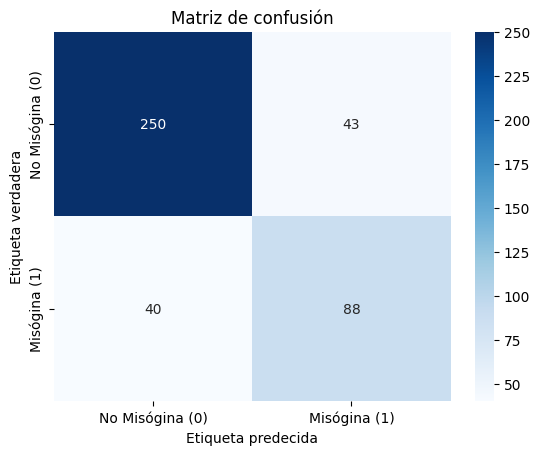

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Calcular y mostrar métricas de rendimiento ---
print(f"\n--- Resultados de la Evaluación (Test Set) ---")
print(f"Total de ejemplos evaluados: {len(true_labels)}")
print(f"Ejemplos donde falló la extracción de la etiqueta: {failed_extractions_count}")

# Si no hay predicciones válidas, mostramos un aviso y no calculamos métricas
if not true_labels or not predicted_labels:
    print("\nNo se pudieron calcular las métricas (no hay predicciones válidas).")
else:
    # 1. Cálculo de métricas principales con sklearn
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1_macro = f1_score(true_labels, predicted_labels, average='macro')       # Promedia F1 entre clases sin ponderar
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted') # Promedia F1 ponderando por frecuencia
    report = classification_report(true_labels, predicted_labels, target_names=['No Misógina (0)', 'Misógina (1)'])
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['0', '1'])

    # 2. Mostramos las métricas
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print("\nReporte de Clasificación Detallado:")
    print(report)

    # 3. Visualizamos la matriz de confusión
    plt.figure()
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['No Misógina (0)', 'Misógina (1)'],
        yticklabels=['No Misógina (0)', 'Misógina (1)']
    )
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predecida')
    plt.title('Matriz de confusión')
    plt.show()

In [ ]:
# --- ANÁLISIS POST-EVALUACIÓN ---

print(f"\n--- Filtrando Resultados para Análisis de Errores ---")
print(f"Resultados totales almacenados: {len(test_results_details)}")
print(f"Fallos de extracción durante la evaluación: {failed_extractions_count}")  # Asegúrate de que esta variable se actualiza correctamente

# Inicializamos listas para categorizar las predicciones
false_positives = []     # Predijo 1 pero era 0
false_negatives = []     # Predijo 0 pero era 1
correct_predictions = [] # Coincidencia exacta

# Clasificamos cada predicción
for result in test_results_details:
    if 'predicted_label' not in result or result['predicted_label'] not in ('0', '1'):
        continue  # Nos aseguramos de que hay predicción válida

    true_label = result['true_label']
    pred_label = result['predicted_label']

    if true_label == pred_label:
        correct_predictions.append(result)
    elif true_label == '0' and pred_label == '1':
        false_positives.append(result)
    elif true_label == '1' and pred_label == '0':
        false_negatives.append(result)

# Mostramos el resumen de errores
print(f"Total Predicciones Correctas: {len(correct_predictions)}")
print(f"Total Falsos Positivos (FP) (True=0, Pred=1): {len(false_positives)}")
print(f"Total Falsos Negativos (FN) (True=1, Pred=0): {len(false_negatives)}")

# --- PREPARACIÓN DE DATOS PARA ANÁLISIS CUALITATIVO ---

# Mostramos algunos falsos negativos
print("\n--- Ejemplo Falsos Negativos (Deberían ser 1, Modelo dijo 0) ---")
for i, fn in enumerate(false_negatives[:15]):
    print(f"\nFN #{i+1}")
    print(f"Letra (inicio): {fn['lyrics'][:200]}...")
    print(f"Salida Completa Modelo:\n{fn['full_output_decoded']}")
    print("-" * 20)

# Mostramos algunos falsos positivos
print("\n--- Ejemplo Falsos Positivos (Deberían ser 0, Modelo dijo 1) ---")
for i, fp in enumerate(false_positives[:15]):
    print(f"\nFP #{i+1}")
    print(f"Letra (inicio): {fp['lyrics'][:200]}...")
    print(f"Salida Completa Modelo:\n{fp['full_output_decoded']}")
    print("-" * 20)

# --- GUARDAMOS LOS ERRORES EN ARCHIVOS JSON PARA REVISIÓN POSTERIOR ---
import json

try:
    with open(f'{path}/data/preds/analisis_falsos_negativos.json', 'w', encoding='utf-8') as f:
        json.dump(false_negatives, f, ensure_ascii=False, indent=2)
    print("\nFalsos Negativos guardados en 'analisis_falsos_negativos.json'")

    with open(f'{path}/data/preds/analisis_falsos_positivos.json', 'w', encoding='utf-8') as f:
        json.dump(false_positives, f, ensure_ascii=False, indent=2)
    print("Falsos Positivos guardados en 'analisis_falsos_positivos.json'")
except Exception as e:
    print(f"Error al guardar los archivos JSON de análisis: {e}")